## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [ ]:
# """
# In jupyter notebook simple logging to console
# """
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# # Test
# logger = logging.getLogger('LOGGER_NAME')

# logger.debug('This is hidden')
# logger.info('So this is shown on the console')
# logger.warning('This too')

In [1]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [2]:
Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])

Close_word = namedtuple('Close_word', ['word', 'distance'])
Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])
Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [ ]:
def seed_the_phrase_dictionary_with_examples(phrase_dict_ ):
    t_string = 'smarter than the average bear'
    w_list = t_string.lower().split()
    ph_id1 = uuid.uuid1()
    phrase_dict_[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'not a hair out of place'
    w_list = t_string.lower().split()
    ph_id2 = uuid.uuid1()
    phrase_dict_[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'three blind mice'
    w_list = t_string.lower().split()
    ph_id3 = uuid.uuid1()
    phrase_dict_[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'i just called to say I love you'
    w_list = t_string.lower().split()
    ph_id4 = uuid.uuid1()
    phrase_dict_[ph_id4] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'up, up in the air'
    w_list = t_string.lower().split()
    ph_id5 = uuid.uuid1()
    phrase_dict_[ph_id5] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'wouldn\'t it be nice'
    w_list = t_string.lower().split()
    ph_id6 = uuid.uuid1()
    phrase_dict_[ph_id6] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'roses are red, violets are blue'
    w_list = t_string.lower().split()
    ph_id7 = uuid.uuid1()
    phrase_dict_[ph_id7] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

#seed_the_phrase_dictionary_with_examples()

In [ ]:
# change this so that it imports into a pandas dataframe, so that we can import conversational 
# prefixes and suffixes manually editied in Excel

import csv

def compile_idiom_lists():
    idiom_list_ = []
    with open('data/idioms_1500.csv', 'r') as idioms_data: 
        for line in csv.reader(idioms_data):
            idiom_list_.extend(line)
    idiom_list_ = idiom_list_[1:]
    return idiom_list_
    
#idiom_list = compile_idiom_lists()


In [ ]:
import pickle
   

## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


#%matplotlib inline

In [45]:
def load_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 

#model = prepare_image_classification_model()

In [167]:
import re
import csv

def get_curated_img_label_dict():    
    img_label_dict = {}

    with open('data/image_net_labels_with_original_index_numbers.txt', newline = '') as labels:                                                                                          
        label_reader = csv.reader(labels, delimiter=' ')
        for label_row in label_reader:
            img_label_dict[label_row[0]] = label_row[2]
            img_label_dict        
             

#     filepath = 'data/imagenet1000_clsidx_to_labels.txt'
#     with open(filepath) as fp:
#         line = fp.readline()
#         cnt = 0
#         pattern = re.compile('([^\s\w]|_)+')
#         while line:
#             cleaner_line = re.sub(r'^"', '', line, flags=re.I)
#             cleaner_line = re.sub(r'^\"{', '', line, flags=re.I)
#             cleaner_line = re.sub(r'"$', '', cleaner_line, flags=re.I)
#             # cleaner_line = re.sub(r'}$', '', cleaner_line, flags=re.I)
#             label_string = cleaner_line.split(':')[1]
#             stripped_string = pattern.sub('', label_string)
#             stripped_string_list = stripped_string.split()
#             img_label_dict[cnt] = stripped_string_list
#             line=fp.readline()
#             cnt+=1

    return img_label_dict

#img_label_dict = get_curated_img_label_dict()

In [168]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [169]:
import random

def get_image_path(img_num):
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    #file_number = rand_num = np.random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( img_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # prepare to show and save image
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img_/255.)
    plt.savefig('data/temp.png',bbox_inches='tight')
    return img_ # It seems futile to return this image

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction(img_label_dict_, prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=1)
    #print( prediction_decoded[0][0][0] )
#   best_prediction_str = prediction_decoded[0][0][1]
    best_prediction_str = img_label_dict_[ prediction_decoded[0][0][0] ]
    print(best_prediction_str)
    return best_prediction_str
#    

    

In [170]:
#!pwd

In [171]:
import pickle
import streamlit

#@st.cache
def image_recognition_pipeline( model_,  img_label_dict_, img_num = np.random.randint(1, 5500)):
    #model_ = prepare_image_classification_model()
    IMAGE_PATH = get_image_path( img_num )
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model_)
    # image_topic_ = extract_best_prediction( img_label_dict_, prediction_array )
    # image_topics_ = [image_topic_]
    image_topics_  = extract_best_prediction( img_label_dict_, prediction_array )
    with open("data/" + "image_topics.pickle", 'wb') as to_write:
        pickle.dump([image_topics_], to_write)
      
    return  img, [image_topics_]

#image_recognition_pipeline(model, img_label_dict )

#model = prepare_image_classification_model()
#img, image_topics = image_recognition_pipeline(model, img_label_dict )
# image_topics

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [292]:
from nltk.corpus import wordnet

def get_synonyms( w ):
    #L = [l.name() if '_' not in l.name() else l.name().split('_') for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset
    #flattened_list = [w if type()]
    #return L #flattened_list
    syn_list = []
    syn_list = [word.split('.')[0] for object_name in \
                                    [syn.name().split('_') for syn in wordnet.synsets( w )[0].hypernyms() ] \
                                    for word in object_name if (('_' not in w) or (word.split('.')[0] != w.split('_')[-1]))]
    #syn_list.extend([word.split('.')[0] for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].lemmas() ] for word in object_name])
    #syn_list=[word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].hypernyms()[0].hyponyms() ] for word in object_name]
    #syn_list.extend([word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].root_hypernyms()] for word in object_name])
 
    return syn_list

In [316]:
get_synonyms( "recreational_vehicle" )

['self-propelled']

In [174]:
#'bird.n.01'.split('.')[0]

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [175]:
from nltk.corpus import words

words_set = set( words.words())

In [176]:
import eng_to_ipa as ipa
import pronouncing as pron

def syllable_count_diff( w1, w2, syllable_count_dict_ ): 
    if w2 not in words_set:
        syllable_count_dict_[w2] = ipa.syllable_count( w2 )
    return abs( syllable_count_dict_[ w1 ] - syllable_count_dict_[ w2 ])
    #return pron.syllable

def same_syllable_count( w1, w2, syllable_count_dict_  ):
    return syllable_count_diff(w1, w2, syllable_count_dict_ ) == 0

def close_syllable_count( w1, w2, syllable_count_dict_, threshold=2):
    return syllable_count_diff( w1, w2, syllable_count_dict_ ) <= threshold

In [177]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w, syllable_count_dict_ ):
    word_length_min = 2
    rhyme_list = pron.rhymes( w )
    #print(rhyme_list)
    #rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if close_syllable_count( w, rhyme, syllable_count_dict_, 1) and len(rhyme) >= word_length_min ]]
    #return [ [rhyme for rhyme  in rhyme_list if close_syllable_count( w, rhyme, syllable_count_dict_, 1) and len(rhyme) >= word_length_min and rhyme in words_set]]
    #return [ [rhyme for rhyme  in rhyme_list if len(rhyme) >= word_length_min and rhyme in words_set]]
 

In [178]:
# pron.rhymes('studio')
# syllable_count_dict_ = dict({'studio': 3})
# get_sized_rhymes('studio', syllable_count_dict_ )
#syllable_count_dict_['studio'] = 3

In [179]:
import fuzzy
import phonetics
import Levenshtein as lev

#soundex = fuzzy.Soundex(4)
dmeta = fuzzy.DMetaphone()

In [180]:
import eng_to_ipa as ipa
def syllable_penalty(w1, w2, syllable_count_dict_, penalty_factor = 0.2):

    return syllable_count_diff( w1, w2, syllable_count_dict_ ) * penalty_factor

In [261]:
def first_letter_discount(w1, w2, discount_value = .6):
    return discount_value if w1[0] == w2[0] else 0

def last_letter_discount(w1, w2, discount_value = .25):
    return discount_value if w1[-1] == w2[-1] else 0

In [182]:
def phonetic_distance(w1, w2, fuzzy_meta_dict_, fuzzy_nysiis_dict_):
#     print('fuzzy soundex', lev.distance( soundex(w1), soundex(w2)) )
#     print('fuzzy dmeta  ', lev.distance( dmeta(w1)[0], dmeta(w2)[0]) )
#     print('phon dmet    ', lev.distance( phonetics.dmetaphone(w1)[0], phonetics.dmetaphone(w2)[0]) )
#     print('phon met     ', lev.distance( phonetics.metaphone(w1), phonetics.metaphone(w2)) )
#     print('fuzzy nysiis ', lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2)) )
#     print('phon nysiis  ', lev.distance( phonetics.nysiis(w1), phonetics.nysiis(w2)) )
#     soundex_dist = lev.distance( soundex(w1), soundex(w2))
    num_of_measures = 1
    sum_of_measures = 0
    if w2 not in words_set:
        fuzzy_nysiis_dict_[w2] = fuzzy.nysiis(w2)
        fuzzy_meta_dict_[w2] = dmeta(w2)[0]
        
    nysiis_dist = lev.distance( fuzzy_nysiis_dict_[w1],fuzzy_nysiis_dict_[w2])
    num_of_measures +=1
    sum_of_measures+= nysiis_dist
    try:
        dmeta_dist  = lev.distance( fuzzy_meta_dict_[w1],fuzzy_meta_dict_[w2])
        num_of_measures +=1
        sum_of_measures+= dmeta_dist
        #return np.mean( np.array([  dmeta_dist, nysiis_dist, pron_dist]) )
    except:
        pass
    try:
        pron_dist = round(lev.distance( pron.phones_for_word(w1)[0], pron.phones_for_word(w2)[0]) /3.5)  
        num_of_measures +=1
        sum_of_measures+= pron_dist
    except:
        pass
    return sum_of_measures/float(num_of_measures)
    # return np.mean( nysiis_dist, pron_dist )
   

In [183]:
#     with open("data/" + "fuzzy_meta_dictionary.pickle", 'rb') as to_read:
#         fuzzy_meta_dict =  pickle.load(to_read)
#     with open("data/" + "fuzzy_nysiis_dictionary.pickle", 'rb') as to_read:
#         fuzzy_nysiis_dict =  pickle.load(to_read)
#     with open("data/" + "syllable_count_dictionary.pickle", 'rb') as to_read:
#         syllable_count_dict =  pickle.load(to_read)

In [184]:
#'sweatshirt' in words_set

In [185]:
#syllable_count_dict['sweatshirt']

In [256]:
from random import random

def make_phon_fam_for_sem_fam_member( w_record, thresh=3 ):
    with open("data/" + "fuzzy_meta_dictionary.pickle", 'rb') as to_read:
        fuzzy_meta_dict =  pickle.load(to_read)
    with open("data/" + "fuzzy_nysiis_dictionary.pickle", 'rb') as to_read:
        fuzzy_nysiis_dict =  pickle.load(to_read)
    with open("data/" + "syllable_count_dictionary.pickle", 'rb') as to_read:
        syllable_count_dict =  pickle.load(to_read)
        
    
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    rhyme_dist = .3
    non_rhyme_penalty = rhyme_dist + .3
    
    # Find words that are not necessarily rhyms but phonetically similar

    rhyme_word_list = get_sized_rhymes( w_record.word, syllable_count_dict )[0]
    rhyme_bounty = len( rhyme_word_list )
    print('length of rhyme list', rhyme_bounty )    
    
    
    for word in words_set:
        phon_dist = phonetic_distance( word, w_record.word, fuzzy_meta_dict, fuzzy_nysiis_dict) 
        if (phon_dist <= thresh) and (word != w_record.word):
            syll_pen = syllable_penalty( word, w_record.word, syllable_count_dict)
            last_let_disc = last_letter_discount(word, w_record.word)
            first_letter_disc = first_letter_discount(word, w_record.word)
            close_word_list.append( Close_word(word.lower(), phon_dist + non_rhyme_penalty + syll_pen - last_let_disc - first_letter_disc ))
        #if len( close_word_list ) > 100:
        #   break
    print(len( close_word_list))       


    
    # Find words that are rhymes
    for word in rhyme_word_list:
            syll_pen = syllable_penalty( word, w_record.word, syllable_count_dict)
            last_let_disc = last_letter_discount(word, w_record.word)
            close_word_list.append( Close_word(word, rhyme_dist + syll_pen - last_let_disc - first_letter_disc) )
            first_letter_disc = first_letter_discount(word, w_record.word)
            #logger.info('word in rhyme_list: ', word)
            
    print(len( close_word_list))           
    #logger.info('returning a phonic family: ')
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [317]:
# To be replaced or enhanced with Word2Vec `most_similar()`
def get_most_similar( w ):  
    synonym_dist_setting = .5
    #list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w ) if syn !=  w.split('_')[0] else (syn, synonym_dist_setting-.5)]
    list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w ) ]
    # Replace the above line with a for loop that takes into account the if w has an underscore, it's first
    # item could be in the syn list and be more related than the the 1 penalty suggests
    
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= w_sim) for w_str, w_sim in list_of_duples ]
    #print("list of semantically close words: ", list_of_close_words)    
    return list_of_close_words

In [295]:
def make_phon_fams_and_sem_family( w ):
    
    if '_' not in w:       
        word_record_ = Close_word(w, 0.0)
    else:
        word_record_ = Close_word(w.split('_')[-1], 0.1)
   
    #phon_fams_word_set = set()
    #phon_fams_word_set.add( word_record )
 
    phon_fams_list = []
    phon_fams_list.append( make_phon_fam_for_sem_fam_member( word_record_ ) )
  
    sem_sim_words = get_most_similar( w )  # Eventually replace with call to Word2Vec

    #phon_fams_word_set = phon_fams_word_set.union( sem_sim_words )
    
    for close_w_record in sem_sim_words:
        #print( close_w_record )
        if( len(close_w_record.word ) >=2 ):
            phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )
        
    print('phon_fams_list length: ', len(phon_fams_list))
    
    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)
   

In [190]:
#make_phon_fams_and_sem_family( "china" )

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

#### Need to write body of function that will convert to phoneticized version of word

In [191]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [192]:
# def get_matching_phrases( w, phrase_dict_ ):
#     matched_id_list = []
#     for phrase_id in phrase_dict_.keys():
#         if w in phrase_dict_[phrase_id].phon_list:
#             matched_id_list.append(phrase_id)
#             #print( phrase_dict_[ phrase_id] )
#             return matched_id_list

In [328]:
def get_matching_phrases( w, phrase_dict_ ):
    matched_id_list = []
    for phrase_id, phrase in phrase_dict_.items():
         if w in phrase.phon_list:
            matched_id_list.append(phrase_id)
            #print( phrase_dict_[ phrase_id] )
            return matched_id_list

In [193]:
#  cycles through each phonetic family in the semantic family to get matching phrases

def get_phrases_for_phon_fam( phon_fam_, phrase_dict_ ):

    word_match_records_ = []

    for word in phon_fam_.close_words:
        matched_phrases = get_matching_phrases( word.word, phrase_dict_ )
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'dist_score': ''})
    print("phon fam's number of word_match_records:", len(word_match_records_ ))
    return word_match_records_ 


In [194]:
def get_phrases_for_sem_fam( sem_fam_, phrase_dict_ ):
    word_match_records_ = []
    for phon_fam_ in sem_fam_.sem_fam_words:
        #print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        phrases_ = get_phrases_for_phon_fam( phon_fam_, phrase_dict_ ) 
        if len( phrases_ ) > 0:
            #print( phrases_ )
            word_match_records_.extend( phrases_ )
        #if len(word_match_records_) > 500:
        #   break
    print("SEM fam's number of word_match_records:", len(word_match_records_ ))
    return word_match_records_

In [195]:
# word_match_records = []   
# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [196]:
# To be replaced with image recognition algorithms
def get_image_topics():
    return [image_topic]


In [197]:
# with open("data/" + "image_topics.pickle", 'rb') as to_read:
#     image_topics_ =  pickle.load(to_read)

# with open("data/" + "phrase_dictionary.pickle", 'rb') as to_read:
#     phrase_dict_ =  pickle.load(to_read)    

# col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']
# cand_df_ = pd.DataFrame(columns= col_names)


In [198]:
# image_sem_fam = make_phon_fams_and_sem_family( image_topics_[0] )

In [199]:
# cand_df_

In [200]:
# image_sem_fam[1]

In [201]:
# get_image_topics()

## The equivalent of `main` for the time being, until two or more image topics are handled

In [202]:
#image_topics_

In [336]:
##### SOMEHWERE IN HERE IS THE BOTTLENECK
def generate_the_captions( ):
    with open("data/" + "image_topics.pickle", 'rb') as to_read:
        image_topics_ =  pickle.load(to_read)
        
    with open("data/" + "phrase_dictionary.pickle", 'rb') as to_read:
        phrase_dict_ =  pickle.load(to_read)    
    
    col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']
    cand_df_ = pd.DataFrame(columns= col_names)

    image_topic_word_ = image_topics_[0]
#   image_topic_word_ = image_topics_
    image_sem_fam = make_phon_fams_and_sem_family( image_topic_word_ )

    word_match_records = get_phrases_for_sem_fam( image_sem_fam, phrase_dict_ )

    cand_df_ = cand_df_.append(word_match_records)
    return cand_df_, image_topic_word_   #, phrase_dict_

#generate_the_captions( )
#cand_df_, image_topic_word_, phrase_dict_= generate_the_captions( )

In [208]:
#cand_df_

In [383]:
def compute_candidate_caption_scores(cand_df_):
    cand_df_['dist_score'] = cand_df_.apply(lambda row: (float(row['sem_dist']) + row['phon_dist']/len(row['semantic_match'])), axis=1)
    return cand_df_

## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [210]:
def construct_caption_by_substitution(row_, phon_match, sem_match, phrase_dict_ ):
    #print (phrase_dict_[ row_['phrase_id'] ])
    original_phrase = phrase_dict_[ row_['phrase_id'] ].text_string
    altered_phrase = original_phrase.replace(phon_match, sem_match)
    return altered_phrase


In [211]:

def get_best_captions(df, phrase_dict_, selection_size=25):
    df.sort_values(by='dist_score', inplace=True)
    best_df = df.head(selection_size)
    best_df['caption'] = best_df.apply(lambda row: construct_caption_by_substitution(row, row['phonetic_match'],  row['semantic_match'], phrase_dict_, ), axis=1 )        # Is it not to pass a dictionary to a function?
    return best_df

In [212]:
def process_best_captions_df_and_make_list(cand_df, phrase_dict):
    best_captions_df = get_best_captions(cand_df, phrase_dict)
    #best_captions_df
    best_captions_list = best_captions_df['caption'].tolist()
    #best_captions_list = [caption.capitalize() for caption in best_captions_df['caption'].to_list()]
    return best_captions_df, best_captions_list

In [368]:
def get_display_df(best_captions_df_):
    best_captions_display_df = best_captions_df_[['caption', 'dist_score', 'semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist']]
    best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())
    best_captions_display_df.set_index('caption', inplace=True)
    return best_captions_display_df

In [214]:
import matplotlib.image as mpimg
img = mpimg.imread('data/temp.png')

In [215]:
# ax = plt.axes([0,0,1,1], frameon=False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.autoscale(tight=True)
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
#plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
#plt.imshow(img)


,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score
1325,mask,0.0,task,0.05,91e0ef2c-854a-11eb-a9e5-acde48001122,0.05
351,mask,0.0,mark,0.50,91e06a16-854a-11eb-a9e5-acde48001122,0.50
705,mask,0.0,milk,0.50,91e012fa-854a-11eb-a9e5-acde48001122,0.50
886,mask,0.0,mice,0.75,91df2ebc-854a-11eb-a9e5-acde48001122,0.75
520,mask,0.0,make,0.75,91e05e86-854a-11eb-a9e5-acde48001122,0.75
...,...,...,...,...,...,...
2672,disguise,0.5,lift,3.80,91e073ee-854a-11eb-a9e5-acde48001122,4.30
1879,disguise,0.5,rob,3.80,91e0cd44-854a-11eb-a9e5-acde48001122,4.30
2799,disguise,0.5,shebang,4.00,91e100f2-854a-11eb-a9e5-acde48001122,4.50
1689,covering,0.5,kith,4.00,91e05eae-854a-11eb-a9e5-acde48001122,4.50


In [216]:
def make_image_with_caption( image, caption):
    ax = plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.text( 0.5, -0.1, caption, \
    horizontalalignment='center', verticalalignment='center', \
    transform=ax.transAxes, fontsize=16)
    plt.imshow( image)

    plt.tight_layout()
    plt.savefig('data/image_with_caption.png')
    plt.show()


In [217]:
# THIS BLOCK WILL EVENTUALLY BE OMMITTED FROM THE APP CODE
def build_phrase_dictionary(idiom_list_, phrase_dict_):

    for idiom_str in idiom_list_:
        w_list = idiom_str.lower().split()
        phrase_dict_[uuid.uuid1()] = Phrase(text_string = idiom_str, word_list = w_list, phon_list = w_list, string_length = len(idiom_str), word_count = len(w_list), prefix="Yeah, right, like  ", phrase_type='idiom' )

    with open("data/" + "phrase_dictionary.pickle", 'wb') as to_write:
        pickle.dump(phrase_dict_, to_write)

In [219]:
# THIS BLOCK WILL EVENTUALLY BE OMMITTED FROM THE APP CODE
# @st.cache
def setup():
    phrase_dict = dict()
    seed_the_phrase_dictionary_with_examples( phrase_dict )

    idiom_list_ = compile_idiom_lists()
    
    build_phrase_dictionary(idiom_list_, phrase_dict )

In [334]:
#def process_captioning_the_image( ):

#def process_captioning_the_image_part0( ):

#def process_captioning_the_image_part1( ):
def process_captioning_the_image_part1( cand_df_, image_topic_word_, phrase_dict_ ):
    
    #cand_df_, image_topic_word_, phrase_dict_ = generate_the_captions()

    cand_df_ = compute_candidate_caption_scores(cand_df_)

    best_captions_df_ = get_best_captions(cand_df_, phrase_dict_)

    return cand_df_, best_captions_df_, phrase_dict_
    
def process_captioning_the_image_part2( cand_df_, best_captions_, phrase_dict_ ):   
    
    best_captions_df_, best_captions_list_ = process_best_captions_df_and_make_list(cand_df_, phrase_dict_)

    img_ = mpimg.imread('data/temp.png')

    return img_, best_captions_list_, best_captions_df_

def process_captioning_the_image_part3( img_, best_captions_list_, best_captions_df_):

    make_image_with_caption( img_, best_captions_list_[0])

    display_df_ = get_display_df( best_captions_df_ )

    return display_df_

#process_captioning_the_image( )

In [221]:
#type(display_df.index.tolist())

In [222]:
#make_image_with_caption( img, display_df.index[0] )

In [223]:
# cand_df_, image_topic_word_, phrase_dict_ = generate_the_captions()


# cand_df_ = compute_candidate_caption_scores(cand_df_)

# best_captions_df = get_best_captions(cand_df_, phrase_dict_)

# best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df_, phrase_dict_)

# img = mpimg.imread('data/temp.png')

# make_image_with_caption( img, best_captions_list[0])

# display_df_ = get_display_df( best_captions_df )

# display_df

In [224]:
# cand_df_, image_topic_word_, phrase_dict_ = generate_the_captions()

In [225]:
# cand_df

In [412]:
def display_image():
    img = mpimg.imread('data/image_with_caption.png')
    try:
        st.image(img, width=800)
    except:
        pass

### Streamlit code

### non-streamlit code

In [243]:
img_label_dict = get_curated_img_label_dict()
img_model = load_image_classification_model()

# setup()

img.shape:  (299, 299, 3)
golf_ball


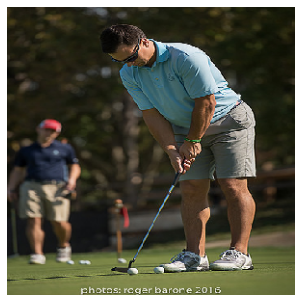

In [402]:
img_num=3300
if img_num is None:
    img_num = 2
    
img, image_topics_list =image_recognition_pipeline(img_model, img_label_dict, img_num )

In [403]:
image_topics_list

['golf_ball']

In [406]:
#display_df = process_captioning_the_image(phrase_dict)
#display_df = process_captioning_the_image()

#cand_df, image_topic_word, phrase_dict = generate_the_captions()
cand_df, image_topic_word = generate_the_captions()


length of rhyme list 96
101151
101247
list of semantically close words:  [Close_word(word='golf', distance=0.5), Close_word(word='equipment', distance=0.5)]
length of rhyme list 2
97502
97504
length of rhyme list 1
92208
92209
phon_fams_list length:  3
phon fam's number of word_match_records: 1318
phon fam's number of word_match_records: 1318
phon fam's number of word_match_records: 168
SEM fam's number of word_match_records: 2804


'window_shade'

In [407]:

cand_df, best_captions_df, phrase_dict = process_captioning_the_image_part1(cand_df, image_topic_word, phrase_dict)

<ipython-input-211-9a4e40ee8091>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['caption'] = best_df.apply(lambda row: construct_caption_by_substitution(row, row['phonetic_match'],  row['semantic_match'], phrase_dict_, ), axis=1 )        # Is it not to pass a dictionary to a function?


In [408]:
best_captions_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score,caption
1311,ball,0.1,call,-0.55,91dffc3e-854a-11eb-a9e5-acde48001122,-0.0375,ball a spade a spade
476,ball,0.1,bull,0.00,91dff82e-854a-11eb-a9e5-acde48001122,0.1000,ball in a china shop
988,ball,0.1,bell,0.00,91dfe924-854a-11eb-a9e5-acde48001122,0.1000,ball the cat
750,ball,0.1,bill,0.00,91e0d3f2-854a-11eb-a9e5-acde48001122,0.1000,sell him a ball of goods
271,ball,0.1,bowl,0.00,91e06278-854a-11eb-a9e5-acde48001122,0.1000,life is a ball of cherries
615,ball,0.1,bail,0.00,91dfe1b8-854a-11eb-a9e5-acde48001122,0.1000,ball out
1314,ball,0.1,paul,0.05,91e0cd44-854a-11eb-a9e5-acde48001122,0.1125,rob peter to pay ball
1317,ball,0.1,wall,0.05,91dfe2bc-854a-11eb-a9e5-acde48001122,0.1125,bang your head against the ball (against a bri...
1316,ball,0.1,tall,0.05,91dfc3a4-854a-11eb-a9e5-acde48001122,0.1125,a ball order
1315,ball,0.1,small,0.05,91e0dbcc-854a-11eb-a9e5-acde48001122,0.1125,ball beer


In [409]:
#cand_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score
1311,ball,0.1,call,-0.55,91dffc3e-854a-11eb-a9e5-acde48001122,-0.0375
476,ball,0.1,bull,0.00,91dff82e-854a-11eb-a9e5-acde48001122,0.1000
988,ball,0.1,bell,0.00,91dfe924-854a-11eb-a9e5-acde48001122,0.1000
750,ball,0.1,bill,0.00,91e0d3f2-854a-11eb-a9e5-acde48001122,0.1000
271,ball,0.1,bowl,0.00,91e06278-854a-11eb-a9e5-acde48001122,0.1000
...,...,...,...,...,...,...
1544,golf,0.5,potatoes,4.00,91e0dc1c-854a-11eb-a9e5-acde48001122,1.5000
1658,golf,0.5,amateur,4.00,91dfd376-854a-11eb-a9e5-acde48001122,1.5000
2166,golf,0.5,together,4.00,91e0c1e6-854a-11eb-a9e5-acde48001122,1.5000
1585,golf,0.5,envelope,4.00,91e0c2cc-854a-11eb-a9e5-acde48001122,1.5000


In [332]:
#phrase_dict['91df2c78-854a-11eb-a9e5-acde48001122']

In [340]:
#cand_df[cand_df['semantic_match']=='window']

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score
2028,window,0.5,wound,0.95,91e0bfac-854a-11eb-a9e5-acde48001122,1.45
2221,window,0.5,wind,0.95,91e02db2-854a-11eb-a9e5-acde48001122,1.45
2352,window,0.5,wounds,0.95,91e06250-854a-11eb-a9e5-acde48001122,1.45
2104,window,0.5,when,1.20,91e112ea-854a-11eb-a9e5-acde48001122,1.70
2260,window,0.5,wood,1.20,91dfdcea-854a-11eb-a9e5-acde48001122,1.70
...,...,...,...,...,...,...
1426,window,0.5,acknowledge,3.80,91dfc638-854a-11eb-a9e5-acde48001122,4.30
2430,window,0.5,scratch,3.80,91e027b8-854a-11eb-a9e5-acde48001122,4.30
2470,window,0.5,molasses,3.80,91e0dba4-854a-11eb-a9e5-acde48001122,4.30
2140,window,0.5,honestly,3.80,91e0029c-854a-11eb-a9e5-acde48001122,4.30


In [367]:
#best_captions_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score,caption
0,mask,0.0,up,2.85,91df2f34-854a-11eb-a9e5-acde48001122,,"mask, mask in the air"
1983,disguise,0.5,taste,2.80,91dfe12c-854a-11eb-a9e5-acde48001122,,bad disguise in your mouth
1984,disguise,0.5,air,3.80,91df2f34-854a-11eb-a9e5-acde48001122,,"up, up in the disguise"
1985,disguise,0.5,south,3.55,91e045fe-854a-11eb-a9e5-acde48001122,,head (go) disguise
1986,disguise,0.5,victory,3.55,91e10e94-854a-11eb-a9e5-acde48001122,,disguise lap
1987,disguise,0.5,bud,3.80,91e07128-854a-11eb-a9e5-acde48001122,,nip (it) in the disguise
1988,disguise,0.5,turkey,3.10,91e033de-854a-11eb-a9e5-acde48001122,,go cold disguise
1989,disguise,0.5,tin,3.55,91dfff54-854a-11eb-a9e5-acde48001122,,cat on a hot disguise roof
1990,disguise,0.5,mend,3.80,91dfe60e-854a-11eb-a9e5-acde48001122,,be on the disguise
1991,disguise,0.5,oyster,3.10,91e10142-854a-11eb-a9e5-acde48001122,,the world is your disguise


In [400]:
img, best_captions_list, best_captions_df = process_captioning_the_image_part2(cand_df, best_captions_df, phrase_dict )

<ipython-input-211-9a4e40ee8091>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['caption'] = best_df.apply(lambda row: construct_caption_by_substitution(row, row['phonetic_match'],  row['semantic_match'], phrase_dict_, ), axis=1 )        # Is it not to pass a dictionary to a function?


In [410]:
#best_captions_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score,caption
1311,ball,0.1,call,-0.55,91dffc3e-854a-11eb-a9e5-acde48001122,-0.0375,ball a spade a spade
476,ball,0.1,bull,0.00,91dff82e-854a-11eb-a9e5-acde48001122,0.1000,ball in a china shop
988,ball,0.1,bell,0.00,91dfe924-854a-11eb-a9e5-acde48001122,0.1000,ball the cat
750,ball,0.1,bill,0.00,91e0d3f2-854a-11eb-a9e5-acde48001122,0.1000,sell him a ball of goods
271,ball,0.1,bowl,0.00,91e06278-854a-11eb-a9e5-acde48001122,0.1000,life is a ball of cherries
615,ball,0.1,bail,0.00,91dfe1b8-854a-11eb-a9e5-acde48001122,0.1000,ball out
1314,ball,0.1,paul,0.05,91e0cd44-854a-11eb-a9e5-acde48001122,0.1125,rob peter to pay ball
1317,ball,0.1,wall,0.05,91dfe2bc-854a-11eb-a9e5-acde48001122,0.1125,bang your head against the ball (against a bri...
1316,ball,0.1,tall,0.05,91dfc3a4-854a-11eb-a9e5-acde48001122,0.1125,a ball order
1315,ball,0.1,small,0.05,91e0dbcc-854a-11eb-a9e5-acde48001122,0.1125,ball beer


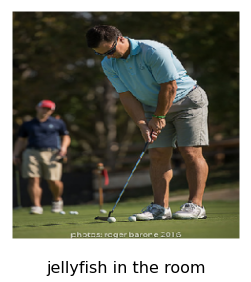

<ipython-input-368-12bec329cc17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())


In [401]:
    
display_df = process_captioning_the_image_part3( img, best_captions_list, best_captions_df)


In [353]:
image_topic_word

'bathing_cap'

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score


In [235]:
display_image()

NameError: name 'st' is not defined

### Streamlit code

### Non-streamlit code

In [ ]:
#get_best_captions(cand_df)

In [ ]:
#image_topic

In [53]:
#display_df

NameError: name 'display_df' is not defined

In [413]:
!jupyter nbconvert --to script amusemater_captioner_cleaned_.ipynb
with open('amusemater_captioner_cleaned____.py', 'r') as f:
    lines = f.readlines()
with open('amusemater_captioner_cleaned____.py', 'w') as f:
    for line in lines:
        if 'nbconvert --to script' in line:
            break
        elif ('# In[' not in line) and (']:' not in line) and ('\%matplotlib inline' not in line):
            f.write(line)

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook amusemater_captioner_cleaned_.ipynb to script
[NbConvertApp] Writing 36148 bytes to amusemater_captioner_cleaned_.py


FileNotFoundError: [Errno 2] No such file or directory: 'amusemater_captioner_cleaned____.py'